# Star Trek Classifier

Ever notice how many species there are in Star Trek? Ever casually watch the show with someone and realize you don't know a Klingon from a Cardassian? 

Ever have both those realizations around the same time as working through a deep learning course?

For this project, I wanted to train an image classifier to distinguish the species from Star Trek. The code and notes in this notebook are heaviliy borrowed from the fast.ai "Deep Learning for Coders" course. In partiular, this notebook takes a lot of code from the file fast ai lesson-1-pets.ipynb.





In [0]:

#  ensure any edits to libraries you make are reloaded here automatically, 
# and ensure any charts or images displayed are shown in this notebook.

%reload_ext autoreload
%autoreload 2
%matplotlib inline

For this project, I use Google Colaboratory (mostly for its gpu).  I set up my code to live on google drive and set up that folder to be a git repo. 

Below, I mount my google drive to be used in google colaboratory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# confirm I have everything I need
from os import listdir
listdir('drive/My Drive/git/fast-ai/star-trek-classifier')

['images',
 'image_downloading.py',
 '.ipynb_checkpoints',
 'image_organizing.py',
 'readme.md',
 'species-classifier.ipynb',
 'star_trek_species_classifier.ipynb']

Next, I import all the necessary packages. I'm working with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [4]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
  
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

!pip install fastai

import fastai
from fastai import *
from fastai.vision import *

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
1.0.0
True
True


In [0]:
from fastai import *
from fastai.vision import *

## Looking at the data

I downloaded images of of five different species of star trek characters for this project. I used the google_images_downloading package to download 100 image results for each of the following searches:


* star trek cardassian
* star trek klingon
* star trek ferengi
* star trek vulcan
* star trek andorian

Why did I pick these species? Honestly, cause I had either heard of them before or thought they looked cool after doing some research. 

I've been informed that the andorians aren't really that common or on the same popularity level as the others. But hey, they look distinctive and I bet we'll do a great job classifying them!


If you run the *image_downloading.py* file in my repo, you'll end up with a "download" folder with each of your search results in their own folder inside that "download" folder. In watching some of the fast.ai lectures, I noticed it was often convenient to have these images seperated in to training and testing folders by class. 

I made a little script that moves all of my search results to the expected train/ test structure for fast.ai. Run image_organizing.py if you're trying to replicate this process.




In [0]:
# set path, where all of your images are
PATH = "drive/My Drive/git/fast-ai/star-trek-classifier/images"


In [7]:
# note this path should have train and validation folders
listdir('drive/My Drive/git/fast-ai/star-trek-classifier/images')


['train', 'valid', 'models']

In [8]:
# each of the train and valid folders should have folders for each class
listdir('drive/My Drive/git/fast-ai/star-trek-classifier/images/train/klingon')


['1. c16185560475db2e8502400a6242915615368391.jpg',
 '3. maxresdefault.jpg',
 '4. worf_what-e1439389305558-640x400.jpg',
 '5. star-trek-discovery-klingons-750x480.jpg',
 '6. latest?cb=20090212231042&path-prefix=en.jpg',
 '7. lloyd.jpg',
 '8. worf1.jpg',
 '9. left-star-trek-into-darkness-klingon-right-general-chang-in-the-undiscovered-country.jpeg',
 '10. klingons-star-trek-discovery.jpg',
 '12. klingon-eras.jpg',
 '13. latest?cb=20110626011805&path-prefix=en.jpg',
 '15. klingon-star-trek-discovery-from-trailer.jpg',
 '18. 6a00d83452033569e2017ee856d291970d-600wi.jpg',
 '19. 1827480.jpg',
 '20. star-trek-discovery-klingon-anatomy.jpg',
 '21. 36538882-a294-11e7-84b5-dfc1701cb40cimagehires162559.jpg',
 '22. 220px-tos-day_of_the_dove_klingons.png',
 '24. latest?cb=20070519161420&path-prefix=en.jpg',
 '23. klingons-1024x367.jpg',
 '25. star-trek-discovery-klingons-1127181-1280x0.jpeg',
 '26. klingons-in-chronological-order-kang-in-the-original-series-a-klingon-captain-in-star-trek-the-m.jpe

In [9]:
# see some files
klingon_files = os.listdir(f'{PATH}/valid/klingon')[:5]
klingon_files

['2. d42fec0f705e18aa21fa08b101dd333c8b8a1934.jpg',
 '11. star-trek-royal-albert-hall-shows-free-tickets-if-you-book-in-klingon-925399.jpg',
 '14. 89d338ac6611f51276a92339882ab9bd147cc551.jpg',
 '16. 8b2ad22d2454acbdd465bf7b1e0a3ba2--star-terk-star-trek-klingon.jpg',
 '17. maxresdefault.jpg']

**Let's look at some of these!**

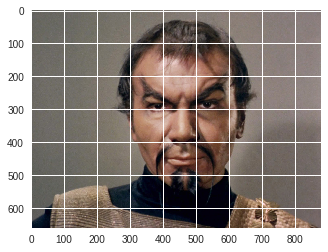

In [10]:
klingon_img = plt.imread(f'{PATH}/valid/klingon/{klingon_files[0]}')
plt.imshow(klingon_img);

In [0]:
# set some other file paths so we can easily print them
cardassian_file = listdir(f'{PATH}/valid/cardassian')[:1]
ferengi_file = listdir(f'{PATH}/valid/ferengi')[:1]
andorian_file = listdir(f'{PATH}/valid/andorian')[:1]
vulcan_file = listdir(f'{PATH}/valid/vulcan')[:1]

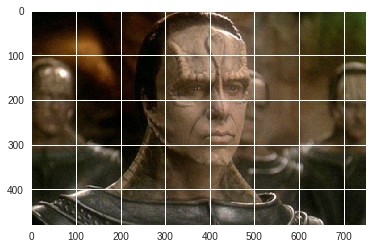

In [12]:
cardassian_img = plt.imread(f'{PATH}/valid/cardassian/{cardassian_file[0]}')
plt.imshow(cardassian_img);



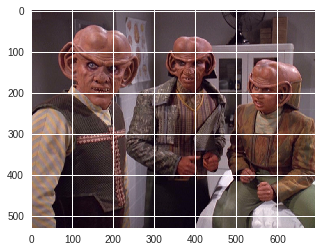

In [13]:
ferengi_img = plt.imread(f'{PATH}/valid/ferengi/{ferengi_file[0]}')
plt.imshow(ferengi_img);

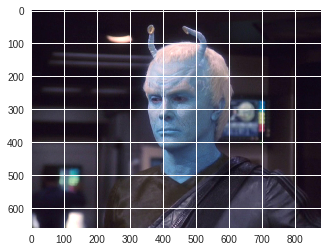

In [14]:
andorian_img = plt.imread(f'{PATH}/valid/andorian/{andorian_file[0]}')
plt.imshow(andorian_img);

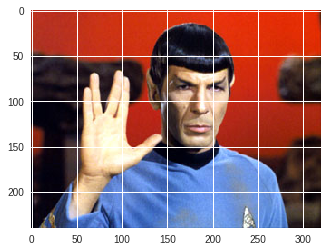

In [15]:
vulcan_img = plt.imread(f'{PATH}/valid/vulcan/{vulcan_file[0]}')
plt.imshow(vulcan_img);

In [16]:
# note that the raw data is something like this for each image:
vulcan_img.shape

(240, 320, 3)

In [17]:
vulcan_img[:4,:4]

array([[[172,  38,  27],
        [177,  43,  31],
        [177,  44,  27],
        [179,  44,  25]],

       [[180,  46,  35],
        [185,  52,  37],
        [184,  51,  34],
        [186,  51,  31]],

       [[176,  42,  30],
        [180,  47,  32],
        [179,  46,  27],
        [181,  46,  26]],

       [[179,  45,  33],
        [182,  49,  34],
        [181,  48,  29],
        [183,  48,  28]]], dtype=uint8)


Next, we use the ImageDataBunch function to set up our data for fast.ai's image classification.

In [0]:
# decare batch size
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart


In [0]:
sz = 224

In [0]:
# we define the data object, including transforming the images so they are all the same size
data = ImageDataBunch.from_folder(PATH, valid='valid', ds_tfms=get_transforms(), size=sz, bs=bs
                                  ).normalize(imagenet_stats)

As you'll see, this data object has all kinds of cool features. See a batch:

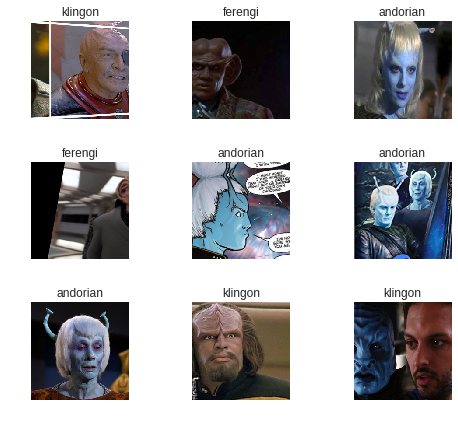

In [21]:
data.show_batch(rows=3, figsize=(7,6))

See the classes:

In [22]:
print(data.classes)

['andorian', 'cardassian', 'ferengi', 'klingon', 'vulcan']


## Initial Model: resnet34

Next, I train an initial model. I use resnet34 to start, a model trained on ImageNet (1.2 million images and 1000 classes). It's a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. 

I train for 4 epochs (4 cycles through all our data), as i noticed when going for a larger number of epochs we were over fitting: the error rate hit a minimum at 4 epochs and then started to go back up.

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [24]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.902998,1.418348,0.561983
2,1.425701,0.803527,0.289256
3,1.147338,0.661376,0.231405
4,0.979608,0.615766,0.231405


In [0]:
learn.save('stage-1')

## Results

Let's look at the results.

First, I want to see which were the categories that the model most confused with one another. Most of the mistakes make sense, as they are generally images where you can't tell what species we're aiming for-- in some cases, there isn't a species at all!

From the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other. This makes sense.

In [80]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

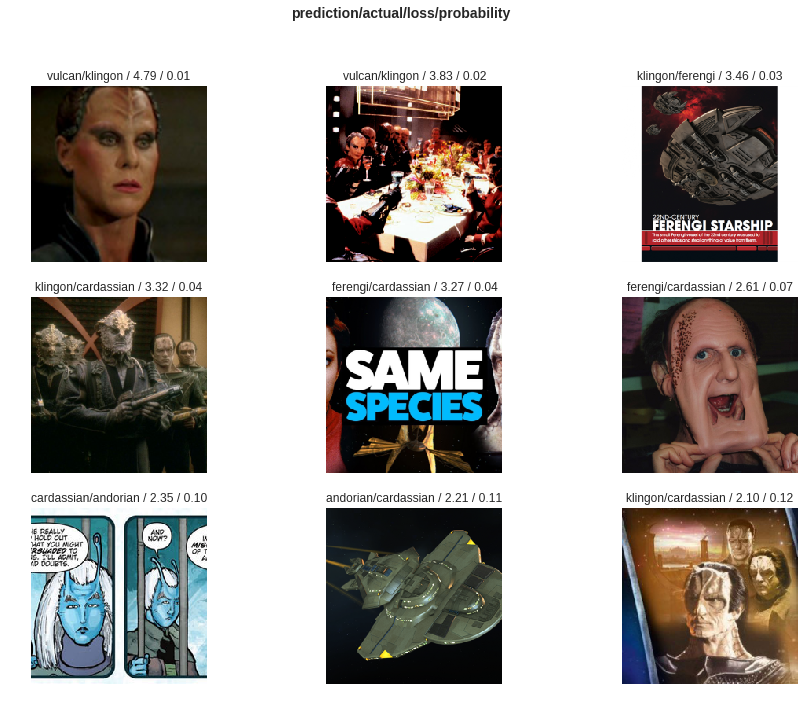

In [81]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

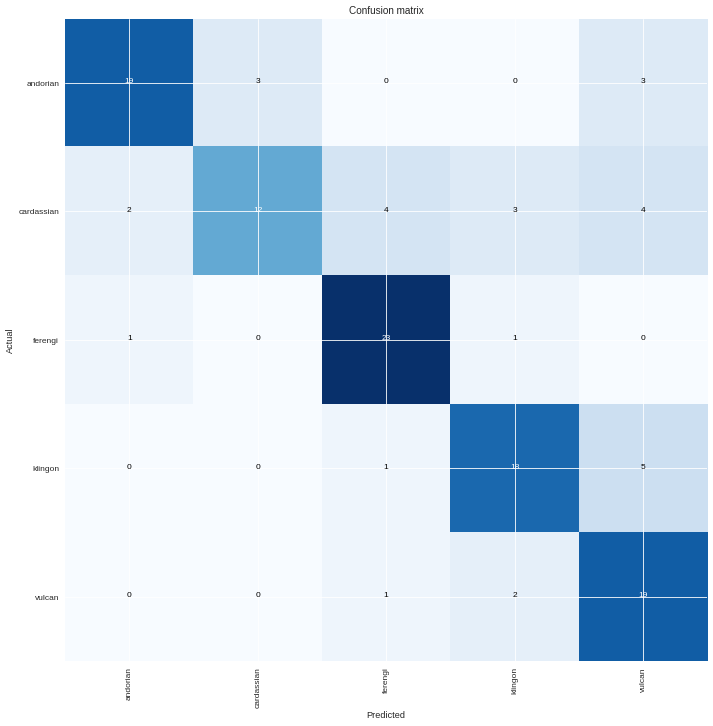

In [83]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [84]:
interp.most_confused(min_val=2)

[('klingon', 'vulcan', 5),
 ('cardassian', 'ferengi', 4),
 ('cardassian', 'vulcan', 4),
 ('andorian', 'cardassian', 3),
 ('andorian', 'vulcan', 3),
 ('cardassian', 'klingon', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.523075,0.724481,0.231405


In [0]:
learn.load('stage-1');

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


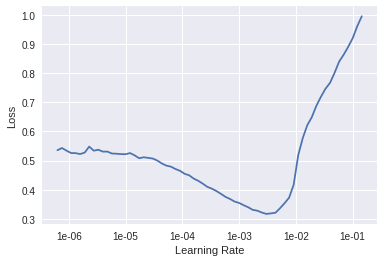

In [30]:
learn.recorder.plot()

In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.472799,0.598017,0.214876
2,0.487355,0.585971,0.223140




```
# This is formatted as code
```

Though not as accurate as the pet species model used in the course, it's pretty good! I'll take 78% accuracy, given I only pulled 100 pictures of each species and spent no time doing data cleaning or removing weird pictures.

## Training: resnet50

Next, I try a resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. 

It should perform better, since resnet50 is a deeper network with more parameters. I also use larger images too, since that way the network can see more detail. Finally, I reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:

# we define the data object, including transforming the images so they are all the same size
data = ImageDataBunch.from_folder(PATH, valid='valid', ds_tfms=get_transforms(), size=299, bs=bs//2
                                  ).normalize(imagenet_stats)



In [33]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 18620018.42it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


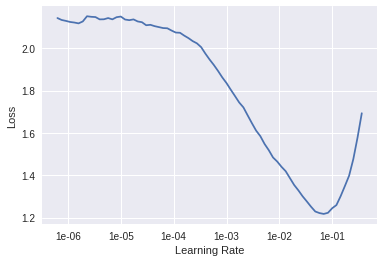

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate
1,1.728797,1.035893,0.363636
2,1.121213,0.609100,0.239669
3,0.840755,0.682643,0.231405
4,0.683356,0.629365,0.223140
5,0.545604,0.593464,0.206612
6,0.454970,0.550892,0.190083
7,0.393250,0.537799,0.173554
8,0.337766,0.536613,0.181818


In [0]:
learn.save('stage-1-50')

It looks like resnet50 did in fact perform better! ~82% accuracy.

Let's see if full fine-tuning helps:

In [37]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.155732,0.534756,0.206612
2,0.150439,0.521353,0.198347
3,0.147657,0.519314,0.198347


In [0]:
# note if the current model isn't bettter, load the previous like this:
#learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [39]:
interp.most_confused(min_val=2)

[('andorian', 'vulcan', 3),
 ('cardassian', 'ferengi', 3),
 ('cardassian', 'klingon', 3)]